In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns


# In this notebook
- Maximum likelihood estimation (MLE)
- MLE - Gaussian distribution
    - Fit of mean
    - Fit of mean + sigma
    - Fit of linear relationship $y=\theta_1 x + \theta_0$
    - Analytic solution
    
# To do
- Provide derivative of likelihood function(s)
- Maximum likelihood estimate for 
    - Exponential distribution
    - Poisson distribution

# Maximum likelihood estimation

Maximum likelihood estimation (MLE) is a method that determines values for the parameters of a model. The parameter values are estimated such that they maximise the likelihood that the process described by the model produced the data that were actually observed. 

For example, what if we want to estimate the mean of a distribution? 
We could use the least-squares algorithm and minimise the mean squared error (MSE). This method finds the optimal model (in this case the mean) by minimising the sum of the squared distrance of all the data points to the estimated mean. In this case, the noise (residuals) is treated as a nuisance and doesn't directly factor in the model, i.e. there are no underlying assumptions about the shape of the noise distribution.  

What if we would make assumptions about the shape of the distribution? In a linear model describing the dependent variable $y$ as the linear combination of independent variable(s) $x$ scaled by the parameter(s) $\theta$

\begin{align}
y = \theta x + \epsilon
\end{align}

the residuals $\epsilon$ are modeled as a random variable drawn from a Gaussian distribution. The Gaussian distribution is described by its probability density function (pdf)

\begin{align}
\mathcal{N}(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(x-\mu)^2}
\end{align}

and is dependent on two parameters: the mean $\mu$ and the variance $\sigma^2$. We can consider the noise to be Gaussian "white noise", with zero mean and unit variance:

\begin{align}
\epsilon \sim \mathcal{N}(0, 1)
\end{align}

In other words, the data is normally distributed around its mean and that therefore when we subtract the mean from this distribution, we expect the residuals to be normally distributed around a mean of zero.


In [2]:
# param
num_samples = 100 # tip: try this out with different sample numbers, with larger numbers probabilities get smaller
sample_mu = 5
sample_sigma = 2

# The Gaussian distribution



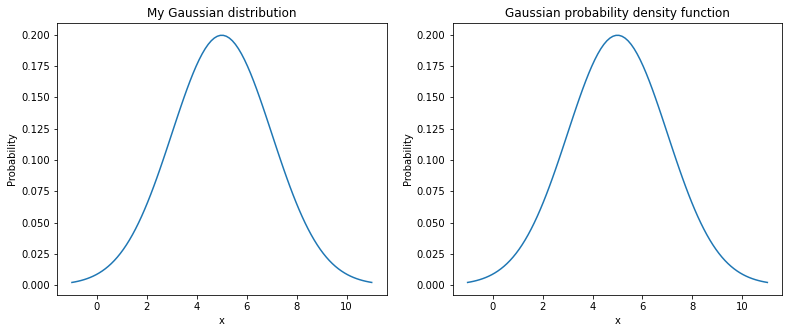

In [3]:
def my_gauss(x,mu,sigma):
    y = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp( -(1/(2*sigma**2)) * (x - mu)**2 )
    return y

# Gaussian 
x = np.linspace(sample_mu-3*sample_sigma, sample_mu+3*sample_sigma, 100)
y1 = my_gauss(x,mu=sample_mu,sigma=sample_sigma)
y2 = norm.pdf(x, loc=sample_mu, scale=sample_sigma)

# plot
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].plot(x,y1)
ax[0].set_title('My Gaussian distribution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Probability')

ax[1].plot(x,y2)
ax[1].set_title('Gaussian probability density function')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Probability')
plt.show()

## Simulate data

Here we simulate some data according to the parameters set above. 

Gaussian fit (built-in function) to data returns mean 5.320631286284851 and sigma 2.2167796671833546


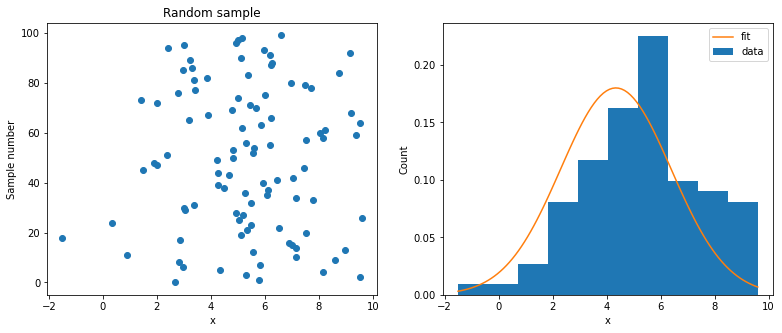

In [4]:
# simulate data
y = sample_mu + sample_sigma * np.random.randn(num_samples)

# fit Gaussian to the data
mean, std = norm.fit(y)
xmin = min(y)
xmax = max(y)
x_fit = np.linspace(xmin, xmax, 100)
y_fit = norm.pdf(x, mean, std)

# plot
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].scatter(y, np.arange(num_samples))
ax[0].set_title('Random sample')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Sample number')

ax[1].hist(y, density=True, label='data')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Count')
ax[1].plot(x_fit, y_fit, label='fit')
ax[1].legend()

print(f'Gaussian fit (built-in function) to data returns mean {mean} and sigma {std}')

plt.show()

## Fit Gaussian to simulated data

We could calculate the probability that this distribution has a specific mean by calculating the joint probability that all the samples in that distribution were drawn from a Gaussian distribution with that mean. As stated above, note that when we compute this, we assume that the noise around the mean is normally distributed with unit variance. 

Lets say we want to test the likelihood that the data was drawn from a distribution with mean 2 and sigma 1. We can calculate the probability that a certain sample $y_i$ was drawn from that distribution by evaluating the Gaussian function (with mean 2) at that value. 

\begin{align}
    P(y_i; \mu, \sigma^2) &= \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y_i-\mu)^2} \\
    P(y_i; \mu=2, \sigma^2=1) &= \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_i-2)^2}
\end{align}

For a value of 4, this would be: 

\begin{align}
    P(y_i =4; \mu=2, \sigma^2=1) &= \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(4-2)^2} = 0.05399
\end{align}

Another way of thinking about this is that we compare an observed value $y_i$ to its predicted value $\hat{y_i}$ (in this case, the predicted value is just the mean of the distribution). If the predicted value differs strongly from the actual value, the likelihood of observing that value given the model parameters is small. This is useful to consider because later $\hat{y}$ will be based on multiple parameters. 

Note that because we are drawing samples from a continuous rather than a discrete distribution, we will use the probability density function instead of discrete probabilities. 

\begin{align}
    P(x_i ; \mu, \sigma) \rightarrow f(x_i ; \mu,\sigma)
\end{align}

Because we assume that all values are independently drawn from this distribution, we take the product of the individual probabilities to compute the total probability of observing all these data points, given the parameters $\mu$ and $\sigma$.
Often, the parameters $\mu$ and $\sigma$ are represented together as a set of parameters $\theta$, such that:

\begin{align}
    \theta = \left \{ \mu, \sigma \right \}
\end{align}


In MLE, the goal is to determine $\theta$ for our data so that we can match our data to its most likely Gaussian bell curve. In other words, which parameters lead to the Gaussian distribution that most likely matches the data points? This product of probabilities (the individual probabilities that each value in $x$ is drawn from a distribution with parameters $\theta$) is what is maximised in maximum likelihood estimation.

\begin{aligned}
    f(x_1,x_2,...,x_n | \theta) &= \prod_i^n f(x_i| \theta) \\
    \hat{\theta}_{MLE} &= \text{argmax}_{\theta}\prod_i^n f(x_i| \theta)
\end{aligned}

One problem with this approach is that the product of probabilities results in an extremely small number that can be numerically unstable, difficult to work with and optimise. Therefore, we take the natural logarithm of this expression.

\begin{aligned}
    \hat{\theta}_{MLE} &= \text{argmax}_{\theta}\sum_i^n \ln(f(x_i| \theta))
\end{aligned}

This is appropriate because the logarithm is a monotonically increasing function, therefore 

\begin{aligned}
    \text{argmax}_{\theta}\prod_i^n f(x_i| \theta) &= \text{argmax}_{\theta}\sum_i^n \ln(f(x_i| \theta))
\end{aligned}


In [5]:
# define My maximim likelihood estimator (MyMLE)
# This instance is to estimate mean and sigma (Gaussian)

class MyMLE:
    
    def __init__(self, y, test_mu, test_sigma):
        self.y = y # observed data (dependent variable)
        self.test_mu = test_mu # test means
        self.test_sigma = test_sigma # test variances
    
    def predict(self, mu):
        
        y_hat = mu # prediction of y based on parameters, in this case the prediction is just the mean
        return y_hat
    
    def gauss(self, y_hat, sigma):
        # probability = norm.pdf(self.data, loc=mu, scale=sigma)        
        probability = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp( -(1/(2*sigma**2)) * (self.y - y_hat)**2 )
        probability = probability + np.finfo(float).eps # add eps to avoid division/multiplication by zero
        return probability
    
    def likelihood(self, probability):
        likelihood = np.prod(probability)
        return likelihood
    
    def log_likelihood(self, probability):
        log_likelihood = np.sum(np.log(probability))
        return log_likelihood  
    
    def evaluate(self):
        
        num_mu = np.shape(self.test_mu)[0]
        num_sigma = np.shape(self.test_sigma)[0]
                
        L = np.zeros((num_mu,num_sigma))
        LL = np.zeros((num_mu,num_sigma))
        
        for imu, mu in enumerate(self.test_mu):
            for isigma, sigma in enumerate(self.test_sigma):
                   
                # predict y_hat
                y_hat = self.predict(mu=mu)
                    
                # get probabilities
                P = self.gauss(y_hat=y_hat, sigma=sigma)
                
                # get likelihood
                L[imu,isigma] = self.likelihood(P)
                
                # get log-likelihood
                LL[imu,isigma] = self.log_likelihood(P)

                
        return {'likelihood':L, 'log-likelihood':LL}     
        

## Fit mean to simulated data

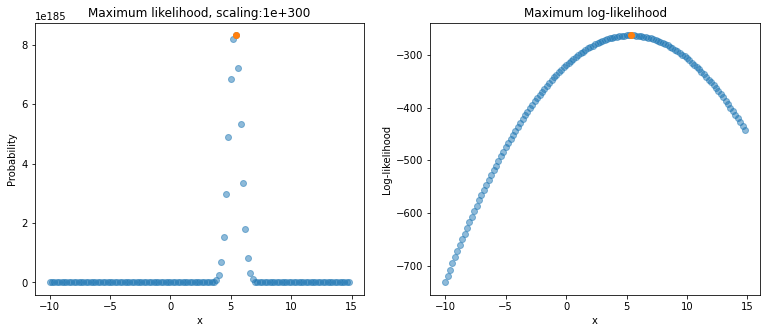

The estimated mean of the distribution (with sigma=[5]) is 5.399999999999945


In [6]:
# define the parameters to evaluate
test_sigma = np.array([5])
test_mu = np.arange(-10,15,0.2)

# fit these parameters
mle = MyMLE(y, test_mu, test_sigma)
L = mle.evaluate()

# find maximum likelihood
idx_L = np.argmax(L['likelihood'][:,0])
idx_LL = np.argmax(L['log-likelihood'][:,0])

# plot
fig,ax = plt.subplots(1,2,figsize=(13,5))

scaling_factor = 1e300
ax[0].scatter(test_mu, L['likelihood']*scaling_factor, alpha=0.5)
ax[0].scatter(test_mu[idx_L], L['likelihood'][idx_L,0]*scaling_factor)
ax[0].set_xlabel('x')
ax[0].set_ylabel('Probability')
ax[0].set_title('Maximum likelihood, scaling:' + str(scaling_factor))
# ax[0].set_ylim()

ax[1].scatter(test_mu, L['log-likelihood'], alpha=0.5)
ax[1].scatter(test_mu[idx_LL], L['log-likelihood'][idx_LL,0])
ax[1].set_xlabel('x')
ax[1].set_ylabel('Log-likelihood')
ax[1].set_title('Maximum log-likelihood')

plt.show()

print(f'The estimated mean of the distribution (with sigma={test_sigma}) is {test_mu[idx_LL]}')


## Fit mean and sigma to simulated data
Above, we evaluated the likelihood that a distribution has a specific mean. Now, we will repeat this for the mean and the standard deviation/variance of the distribution.

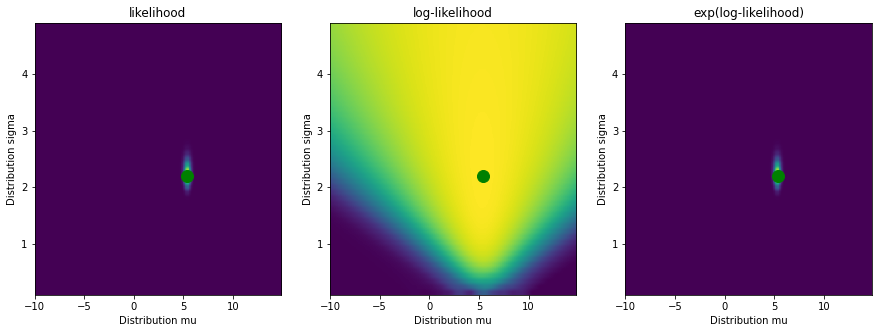

The estimated mean/sigma is 5.399999999999945/2.2


In [7]:
# estimate mean and standard deviation of distribution 

test_sigma = np.arange(0.1,5,0.1)

mle2 = MyMLE(y, test_mu, test_sigma)
L = mle2.evaluate()

idx_max_L = np.unravel_index(np.argmax(L['likelihood']), L['likelihood'].shape, order='C')
idx_max_LL = np.unravel_index(np.argmax(L['log-likelihood']), L['log-likelihood'].shape, order='C')

# plot
fig,ax = plt.subplots(1,3,figsize=(15,5))

# plot probabilities/likelihood
ax[0].imshow(L['likelihood'].T,
             origin='lower', 
             aspect='auto', 
             extent=(test_mu[0], test_mu[-1], test_sigma[0], test_sigma[-1])
            )
ax[0].plot(test_mu[idx_max_L[0]], test_sigma[idx_max_L[1]], 
           color='green', marker='o', markersize=12)
ax[0].set_xlabel('Distribution mu')
ax[0].set_ylabel('Distribution sigma')
ax[0].set_title('likelihood')

# plot log-likelihood
ax[1].imshow(L['log-likelihood'].T,
             origin='lower', 
             aspect='auto', 
             extent=(test_mu[0], test_mu[-1], test_sigma[0], test_sigma[-1])
            )
ax[1].plot(test_mu[idx_max_LL[0]], test_sigma[idx_max_LL[1]], 
           color='green', marker='o', markersize=12)
ax[1].set_xlabel('Distribution mu')
ax[1].set_ylabel('Distribution sigma')
ax[1].set_title('log-likelihood')


# plot exp(log-likelihood)
ax[2].imshow(np.exp(L['log-likelihood'].T),
             origin='lower', 
             aspect='auto', 
             extent=(test_mu[0], test_mu[-1], test_sigma[0], test_sigma[-1])
            )
ax[2].plot(test_mu[idx_max_LL[0]], test_sigma[idx_max_LL[1]], 
           color='green', marker='o', markersize=12)
ax[2].set_xlabel('Distribution mu')
ax[2].set_ylabel('Distribution sigma')
ax[2].set_title('exp(log-likelihood)')
plt.show()

# LL = L['log-likelihood']
print(f'The estimated mean/sigma is {test_mu[idx_max_LL[0]]}/{test_sigma[idx_max_LL[1]]}')


Above, we evaluated the likelihood that a distribution has a specific mean and standard deviation/variance. To build an intuition, repeat this with different parameters and number of samples. 


## Fitting a straight line

Lets expand this to fitting a line instead of only the mean. Here, the measurement $y$ is believed to be proportional to the input variable $x$ with some added measurement noise $\epsilon$. 

$$y_{n}= \theta x_{n}+\epsilon_{n}$$

Our estimate of $y$, $\hat{y}$ is thus some scaled version of $x$ with an offset. The likelihood function therefore is

\begin{align}
    \hat{y_i} &= \theta_1 x_i + \theta_0 \\
    \mathcal{L}(y_i; \theta) &= \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y_i-\hat{y})^2} \\
\end{align}



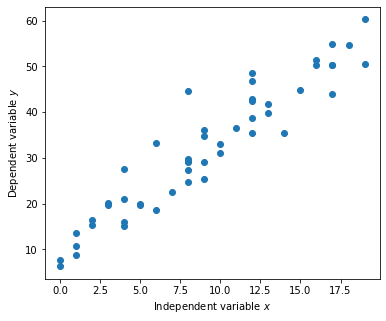

In [8]:
num_samples = 50

sample_sigma = 4
theta1 = 2.5 # slope
theta0 = 10 # intercept

noise = np.random.randn(num_samples) * sample_sigma
x = np.random.randint(low=0, high=20, size=num_samples)

y = theta1 * x + theta0 + noise 


# plot
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(x,y)
ax.set_xlabel('Independent variable $x$')
ax.set_ylabel('Dependent variable $y$')
plt.show()


## Updating MyMLE
Below I redefined the MyMLE class to incorporate the relationship between $x$ and $y$. Note that this (other than some coding details) is largely done by updating our definition of $\hat{y}$ in the `MyMLE.predict` function. 

In [9]:
# define My maximim likelihood estimator (MyMLE)
# This instance is to estimate a linear relationship between x and y (y=b1*x+b0), 
# with noise distribution with specific sigma (Gaussian)

class MyMLE:
    
    def __init__(self, x, y, test_sigma, test_intercept, test_slope):
        self.x = x # input data (independent variable)
        self.y = y # observed data (dependent variable)
        self.test_sigma = test_sigma
        self.test_intercept = test_intercept
        self.test_slope = test_slope
        
    def predict(self, intercept, slope):
        
        y_hat = slope*self.x + intercept # prediction of y based on parameters
        return y_hat
    
    def gauss(self, y_hat, sigma):
        probability = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp( -(1/(2*sigma**2)) * (self.y - y_hat)**2 )
        probability = probability + np.finfo(float).eps # add eps to avoid division/multiplication by zero
        return probability
    
    def likelihood(self, probability):
        likelihood = np.prod(probability)
        return likelihood
    
    def log_likelihood(self, probability):
        log_likelihood = np.sum(np.log(probability))
        return log_likelihood  
    
    def evaluate(self):
        
        num_sigma = np.shape(self.test_sigma)[0]
        num_intercept = np.shape(self.test_intercept)[0]
        num_slope = np.shape(self.test_slope)[0]
                
        L = np.zeros((num_sigma,num_intercept,num_slope))
        LL = np.zeros((num_sigma,num_intercept,num_slope))
        
        for isigma, sigma in enumerate(self.test_sigma):
            for iintercept, intercept in enumerate(self.test_intercept):
                for islope, slope in enumerate(self.test_slope):   

                    # predict y_hat
                    y_hat = self.predict(intercept=intercept, slope=slope)

                    # get probabilities
                    P = self.gauss(y_hat=y_hat, sigma=sigma)

                    # get likelihood
                    L[isigma,iintercept,islope] = self.likelihood(P)

                    # get log-likelihood
                    LL[isigma,iintercept,islope] = self.log_likelihood(P)

                
        return {'likelihood':L, 'log-likelihood':LL}     
        

In [10]:
# fit models, determine mle
test_intercept = np.arange(-10,15,0.2)
test_sigma = np.arange(0.1,5,0.1)
test_slope = np.arange(0.1,5,0.1)

mle3 = MyMLE(x, y, test_sigma, test_intercept, test_slope)
L = mle3.evaluate()

idx_max_LL = np.unravel_index(np.argmax(L['log-likelihood']), L['log-likelihood'].shape, order='C')
print(f'The estimated (true) sigma is {test_sigma[idx_max_LL[0]]} ({sample_sigma})')
print(f'The estimated (true) intercept is {test_intercept[idx_max_LL[1]]} ({theta0})')
print(f'The estimated (true) slope is {test_slope[idx_max_LL[2]]} ({theta1})')

The estimated (true) sigma is 4.5 (4)
The estimated (true) intercept is 10.199999999999928 (10)
The estimated (true) slope is 2.4000000000000004 (2.5)


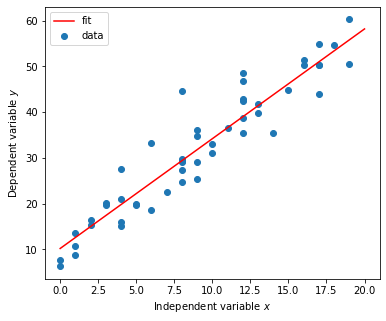

In [11]:
x_fit = np.linspace(0,20,100)
y_fit = test_slope[idx_max_LL[2]] * x_fit + test_intercept[idx_max_LL[1]] 

# plot
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(x, y, label='data')
ax.plot(x_fit, y_fit, color='red', label='fit')
ax.set_xlabel('Independent variable $x$')
ax.set_ylabel('Dependent variable $y$')
ax.legend()
plt.show()


## Analytic solution to mle (only Gaussian)
Clearly, the above solutions are inefficient and if your estimates don't include the correct parameters, they will be inaccurate. As the goal is to maximise the log-likelihood of the model fit (or minimise the negative log-likelihood), we can take the derivative of the log-likelihood function, set it to 0, and solve for our parameters. 
Cleaning up this equation results in the same solution as the least squares solution.


In [12]:
# Analytic solution MLE
design_matrix = np.concatenate([np.ones([num_samples,1]), x[:,np.newaxis]], axis=1)
theta_hat_mle = np.linalg.solve(design_matrix.T@design_matrix, design_matrix.T@y)

print(f'analytic solution to line fit, coefficients: {theta_hat_mle}')

analytic solution to line fit, coefficients: [9.85923146 2.44374256]


## Links
- [Maximum likelihood estimation, 1D](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1)
- [Maximum likelihood estimation, mu and sigma: theoretical](https://towardsdatascience.com/maximum-likelihood-estimation-explained-normal-distribution-6207b322e47f)
- [reliawiki, Maximum Likelihood Estimation Example](https://www.reliawiki.com/index.php/Appendix:_Maximum_Likelihood_Estimation_Example)


# MLE - Poisson distribution

to do

# Appendices

## Maximum likelihood estimation derivative - Gaussian

to do
